In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (8, 6)
# we use regex here to parse the output log files
import re

Populating the interactive namespace from numpy and matplotlib


In [2]:
# global variables
FOLDER_PREFIX="worker"

worker_num_interval = [2, 4, 8, 16, 32]
# single node means, we have single worker node in cluster (ps+worker0)
single_node_time=526.16
# signle machine means we only consider training on local machine, thus there is no communication cost
single_machine_time=526.16

# Parsing TensorFlow output files

In [3]:
global_dict_saver = []
for num_w in worker_num_interval:
    # master is also include in this one, so the first worker should be the master
    time_stats_dict = {}
    for worker_index in range(num_w):
        if worker_index == 0:
            out_file=open(FOLDER_PREFIX+str(num_w)+'/out_master', 'rb')
        else:
            # for the case of 8 workers, we only consider master, worker0,...,worker6
            out_file=open(FOLDER_PREFIX+str(num_w)+'/out_worker_'+str(worker_index-1), 'rb')
        for line in out_file.readlines():
            line_string = line.rstrip('\n')
            search_sth = re.match('INFO:tensorflow:Worker(.*): (.*): step (.*), loss = (.*).* examples/sec; (.*) sec/batch.*', line_string)
            if search_sth:
                worker_index, cur_step, worker_time_cost = int(search_sth.group(1)), int(search_sth.group(3)), float(search_sth.group(5))
                if cur_step <= 40:
                    #print(worker_index, cur_step, worker_time_cost)
                    if cur_step not in time_stats_dict.keys():
                        time_stats_dict[cur_step]=[worker_time_cost]
                    else:
                        time_stats_dict[cur_step].append(worker_time_cost)
    global_dict_saver.append(time_stats_dict)

normal_speedup_vals = [1.0,]
ideal_speedup_vals = [1.0,]
normal_speedup_vals_local = [1.0,]
ideal_speedup_vals_local = [1.0,]
for dict_idx, stat_dict in enumerate(global_dict_saver):
    ideal_counter_ = 0
    full_counter_ = 0
    for k, v in stat_dict.iteritems():
        sorted_v = sorted(v)
        #ideal_counter_+=sorted_v[0]
        #full_counter_+=sorted_v[worker_num_interval[dict_idx]-1]
        ideal_counter_+=min(v)
        full_counter_+=max(v)
    normal_speedup_vals.append(float(single_node_time)/full_counter_)
    ideal_speedup_vals.append(float(single_node_time)/ideal_counter_)
    normal_speedup_vals_local.append(float(single_machine_time)/full_counter_)
    ideal_speedup_vals_local.append(float(single_machine_time)/ideal_counter_)
    print("Cluster set up with {} workers: ideal time: {} full time:{}".format(worker_num_interval[dict_idx], ideal_counter_, full_counter_))

Cluster set up with 2 workers: ideal time: 258.733 full time:263.08
Cluster set up with 4 workers: ideal time: 132.355 full time:135.148
Cluster set up with 8 workers: ideal time: 66.279 full time:81.005
Cluster set up with 16 workers: ideal time: 34.308 full time:44.141
Cluster set up with 32 workers: ideal time: 47.809 full time:72.277


# parsing MPI output files

In [26]:
subfix = 'workers_b8k'
num_worker = [1, 2, 4, 8, 16 ,32]
stats = []
for w in num_worker:
    stat_dict = {}
    with open(str(w)+subfix, 'rb') as worker_file:
        for line in worker_file.readlines():
            line_string = line.rstrip('\n')
            #print(line_string)
            search_sth = re.match('Worker: (.*), Cur Step: (.*), Train Epoch: .* \[.*/.* \(.*%\)\], Train Loss: .*, Time Cost: (.*), FetchWeight: (.*), Forward: (.*), Backward: (.*)', line_string)
            if search_sth:
                worker_id, cur_step, time_cost = search_sth.group(1), int(search_sth.group(2)), float(search_sth.group(3))
                if cur_step <= 100:
                    if cur_step not in stat_dict.keys():
                        stat_dict[cur_step] = [time_cost]
                    else:
                        stat_dict[cur_step].append(time_cost)
        stats.append(stat_dict)

#processing results:
time_costs = []
ideal_time_costs = []
for i, dic in enumerate(stats):
    tmp_time_costs = []
    tmp_ideal_time_costs = []
    for k, v in dic.iteritems():
        tmp_time_costs.append(max(v))
        tmp_ideal_time_costs.append(min(v))
    time_costs.append(sum(tmp_time_costs))
    ideal_time_costs.append(sum(tmp_ideal_time_costs))
    
print(time_costs)
print(ideal_time_costs)
print
speed_ups = [time_costs[0]/i for i in time_costs]
ideal_speed_ups = [ideal_time_costs[0]/i for i in ideal_time_costs]
print(speed_ups)
print(ideal_speed_ups)

[339.82600000000002, 163.54740000000001, 98.637400000000014, 57.610900000000001, 34.688599999999994, 61.836100000000009]
[339.82600000000002, 153.72210000000001, 88.110199999999992, 46.575800000000001, 29.909700000000001, 48.650200000000005]

[1.0, 2.0778440990196114, 3.445204354534892, 5.8986407086159049, 9.7964749225970511, 5.495592380502651]
[1.0, 2.2106515588845066, 3.8568292887770093, 7.2961924432859986, 11.361732147096093, 6.9850894754800592]


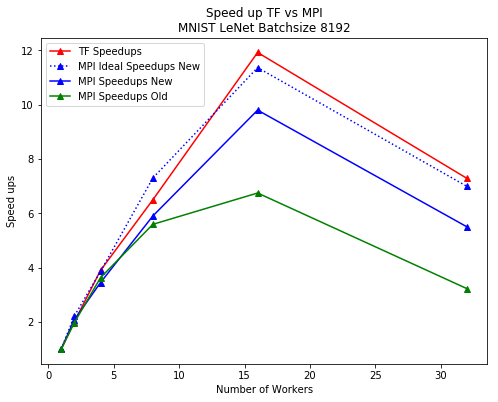

In [27]:
workers_interval=[1, 2, 4, 8, 16, 32]
normal_speedup_vals_mpi_broadCast=[1, 1.97, 3.625, 5.5909, 6.744, 3.22]
ideal_speedup_vals_mpi_broadCast=[1, 2.0859, 5.1640, 7.368877, 10.8139, 7.87878]
fig = plt.figure(1)
#plt.plot(workers_interval, ideal_speedup_vals, ':^r', label='TF Ideal Speedups')
plt.plot(workers_interval, normal_speedup_vals, '-^r', label='TF Speedups')
plt.plot(workers_interval, ideal_speed_ups, ':^b', label='MPI Ideal Speedups New')
plt.plot(workers_interval, speed_ups, '-^b', label='MPI Speedups New')
plt.plot(workers_interval, normal_speedup_vals_mpi_broadCast, '-^g', label='MPI Speedups Old')
#plt.plot(workers_interval, ideal_speedup_vals_mpi_broadCast, ':^g', label='MPI Ideal Speedups Old')
plt.title("Speed up TF vs MPI\nMNIST LeNet Batchsize 8192")
plt.xlabel("Number of Workers")
plt.ylabel("Speed ups")
plt.legend()
#plt.savefig("straggler_ideal_speedup_comparison.jpg", dpi=300)
plt.show()